## AB-тест на revenue 


### Определение функций

In [ ]:
#подключаемся к библиотекам
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
# Построение гистограмм
def hists (samp1, samp2, txt1='', txt2='', title=''):
    sns.set(rc={'figure.figsize':(12,5)})
    sns.histplot(samp1, color = '#00140b', alpha = 0.7, label = txt1, edgecolor='#004524')
    sns.histplot(samp2, color = '#ff2957', alpha = 0.6, label = txt2, edgecolor='#ff2957')
    plt.xlabel('')
    plt.legend(fontsize = 13)
    plt.title(title, fontsize = 15)
    plt.show()

In [ ]:
# функция расчёта p_value для двух выборок Т-тестом

def t_test (samp1, samp2):
    p_val = stats.ttest_ind(samp1, samp2,
                equal_var=False)[1]
    
    print(f'Т-тест Стьюдента дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [ ]:
# функция расчёта p_value двух выборок тестом Манна-Уитни
def t_mann (samp1, samp2):
    p_val = stats.mannwhitneyu(
        samp1, samp2,
        alternative = 'two-sided')[1]
    
    print(f'Тест Манна-Уитни дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [ ]:
# Пуассновский бутстрап
def poisson_bootstrap(metric1, metric2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(metric1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(metric2))).astype(np.int64)
    
    boot_metric1 = (poisson_bootstraps1*metric1).mean(axis=1)
    boot_metric2 = (poisson_bootstraps2*metric2).mean(axis=1)
    
    return boot_metric1, boot_metric2

In [ ]:
# функция вывода распределения разниц и границами, исполбьзуется после бустрапа

def hist_boost (samp, title='', set_bins = 50):
    sns.set(rc={'figure.figsize':(12,5)})
    samp_mean = samp.mean()
    sigma = 1.96 * samp.var() / len(samp)**0.5
    
    plt.axvline(x = 0, color='#ff033e', linewidth=2) # визуальная проверка на включение в разницу нуля
    
    plt.gca().add_patch(Rectangle(
        (np.quantile(samp, 0.05/2), 0),
        np.quantile(samp, 1-0.05/2)-np.quantile(samp, 0.05/2),
        len(samp)/10,
        edgecolor = 'black',
        facecolor = 'pink',
        alpha = 0.4,
        label='ДИ 95%',
        fill=True
    ))
    
    sns.histplot(samp, color = '#013220', alpha=0.6, label='Разница')
    plt.title(title, fontsize = 15)
    plt.legend()
    plt.show()

    return f"CI 95% = [{np.quantile(samp, 0.05/2):.2f}, {np.quantile(samp, 1-0.05/2):.2f}]"

### Предварительный анализ

На сайте был проведен А/В тест с целью увеличить доход. Наша цель - провести анализ, полученных в результате данных.

Н0 - средний доход от одного пользователя остался неизменным, Н1 - средний доход от одного пользователя изменился.

In [ ]:
df = pd.read_excel('/content/AB_Test_Results.xlsx')

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
df_control = df[df.VARIANT_NAME == 'control'].copy()
df_target = df[df.VARIANT_NAME == 'variant'].copy()

4_984 - Объём control группы
5_016 - Объём target группы
0.13 - Среднее control группы
0.07 - Среднее target группы


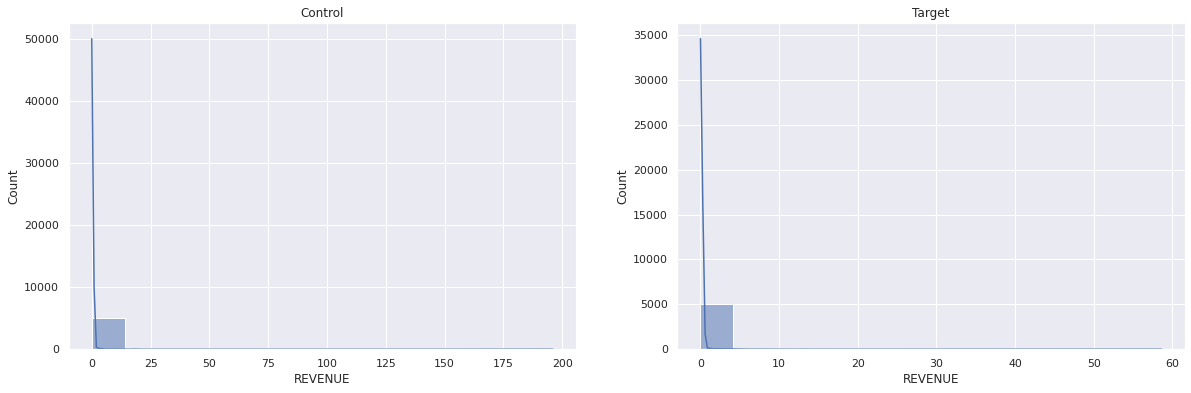

In [ ]:
sns.set(rc={'figure.figsize':(20,6)})
fig, axes = plt.subplots(1, 2)
sns.histplot(df_control, ax = axes[0], x='REVENUE', kde = True).set_title('Control')
sns.histplot(df_target, ax = axes[1], x='REVENUE', kde = True).set_title('Target')
fig.show()
print(f"{df_control.USER_ID.count():_} - Объём control группы\n{df_target.USER_ID.count():_} - Объём target группы")
print(f"{df_control.REVENUE.mean():.2f} - Среднее control группы\n{df_target.REVENUE.mean():.2f} - Среднее target группы")

В кейсе нам необходимо выяснить произошли ли стат значимые изменения прибыли, и если да, то в каккую сторону.

Видим, что распредление прибыли ненормальное, сконцентрировано у нуля и имеет хвост в виде немногочисленных положительных значений. 

В ходе теста revenue упала, но пока нет оснований утверждать - значимо или нет. 

Объем выборок одного масштаба, что увеличивает чувствительность тестов.

In [ ]:
print(f"{df_control[df_control.REVENUE != 0].shape[0]} - Ненулевые control группы\n{df_target[df_target.REVENUE != 0].shape[0]} - Ненулевые target группы")

80 - Ненулевые control группы
72 - Ненулевые target группы


Практически все значения - нулевые, и из-за многочисленно повторящихся значений мы не можем использовать U-критерий для проверки - поменялось ли распределение прибыли после теста.

И из-за сильной скошенности мы не можем использовать Т-критерий, т.к. среднее выборок не будет распредлеено нормально.

Поэтому для проверки гипотезы об изменение средней прибыли среди всех пользователей мы будем использовать бутстрап.

Посмотрим как справочные метрики, которые как правило сонаправлены с основной, также Конверсию пользователя в покупателя и распредление прибыли среди только платящих пользователей.

In [ ]:
print(f"{(df_control.REVENUE != 0).mean()*100:.2f}% - CR в покупку control\n{(df_target.REVENUE != 0).mean()*100:.2f}% - CR в покупку target")

1.61% - CR в покупку control
1.44% - CR в покупку target


Наблюдаем падение метрики. С помощью z-теста пропорций проверим является ли оно значимым или случайным.

80 - Объём control группы
72 - Объём target группы
8.04 - Среднее control группы
4.88 - Среднее target группы


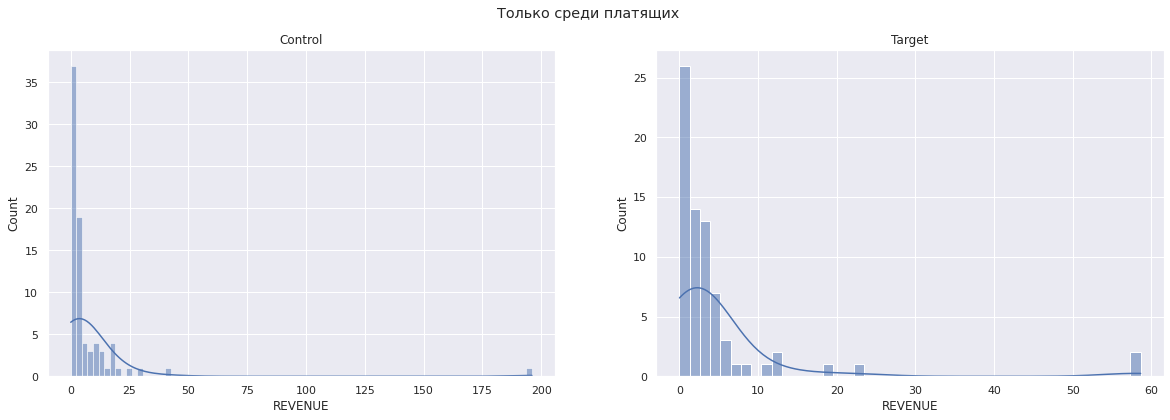

In [ ]:
sns.set(rc={'figure.figsize':(20,6)})
fig, axes = plt.subplots(1, 2)
sns.histplot(df_control[df_control.REVENUE != 0], ax = axes[0], x='REVENUE', kde = True).set_title('Control')
sns.histplot(df_target[df_target.REVENUE != 0], ax = axes[1], x='REVENUE', kde = True).set_title('Target')
fig.suptitle('Только среди платящих')
fig.show()
print(f"{df_control[df_control.REVENUE != 0].USER_ID.count():_} - Объём control группы\n{df_target[df_target.REVENUE != 0].USER_ID.count():_} - Объём target группы")
print(f"{df_control[df_control.REVENUE != 0].REVENUE.mean():.2f} - Среднее control группы\n{df_target[df_target.REVENUE != 0].REVENUE.mean():.2f} - Среднее target группы")

Тут более заметна разница между группами в средних, но она обусловлена наличием выброса + небольшими размерами групп.

In [ ]:
df_control.groupby(by='REVENUE', as_index=False).agg(cnt = ('REVENUE','count')).sort_values('cnt', ascending=False).head()

,REVENUE,cnt
0,0.00,4904
9,1.25,5
33,3.25,4
38,4.33,3
23,2.17,3


In [ ]:
df_target.groupby('REVENUE', as_index=False).agg(cnt = ('REVENUE','count')).sort_values('cnt', ascending=False).head()

,REVENUE,cnt
0,0.00,4944
12,1.25,5
10,1.01,4
2,0.04,3
35,3.75,2


В этой метрике нет большого кол-ва повторяющихся значений, поэтому мы можем использовать U-критерий для проверки - поменялось ли распределение прибыли среди приносящих доход.

Распредление тем неменее остается сильно скошенным - поэтому Т-тест использовать не вариант.

### Анализ

Для анализа метрики дохода от пользователей используем бустрап.

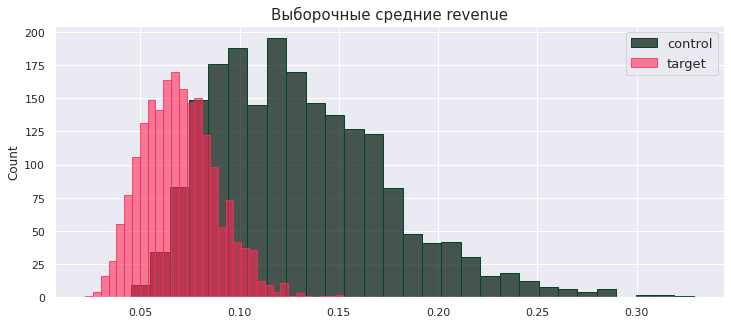

p_value = 0.43


In [ ]:
boot_control, boot_target = poisson_bootstrap(df_control.REVENUE.to_numpy(), df_target.REVENUE.to_numpy())
hists(boot_control, boot_target, 'control', 'target', 'Выборочные средние revenue')
print(f"p_value = {np.mean(boot_target > np.quantile(boot_control, 0.05)):.2f}")

В результате мы получили распредления средних обеих групп. Сравнив их, мы рассчитали p_value = 0.41 > alpha = 0.05. Поэтому у нас нет оснований отвергнуть Н0 и принять Н1. Будем считать, что разница средних в эксперименте - случайна.

In [ ]:
stats.normaltest(boot_control)[1], stats.normaltest(boot_target)[1], stats.normaltest(boot_target - boot_control)[1]

(2.823060301657305e-47, 4.8290612083471525e-17, 1.167765643130144e-27)

Как и говорилось ранее - распределения средних обеих выборок и их разницы - ненормально, поэтому у нас не было оснований использовать Т-тест.

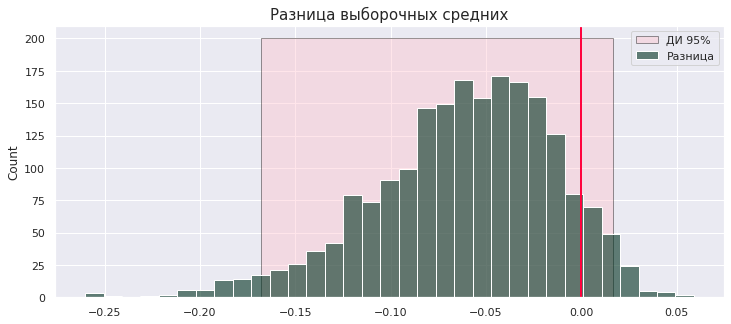

CI 95% = [-0.17, 0.02]


In [ ]:
ci = hist_boost(boot_target - boot_control, 'Разница выборочных средних')
print(f'{ci}')

Доверительный интервал разницы включает ноль, что также говорит о том, что у нас нет оснований называть считать наблюдаемую разницу между группами неслучайной.

In [ ]:
p_val_prop = proportions_ztest([df_control[df_control.REVENUE != 0].shape[0], df_target[df_target.REVENUE != 0].shape[0]],[df_control.shape[0], df_target.shape[0]],  \
                                alternative = 'two-sided')[1]
print(f"p_value CR = {p_val_prop:.2f}")
print(f"CI разницы {100*(proportion_confint(df_target[df_target.REVENUE != 0].shape[0], df_target.shape[0]) - (df_control.REVENUE != 0).mean())}, в %")

p_value CR = 0.49
CI разницы [-0.49889749  0.15943801], в %


Z-тест пропорций по Конверсии в покупателя также не дал оснований отвергнуть Н0, поэтому мы ее принимаем и считаем результаты случайными.

In [ ]:
t_mann(df_control[df_control.REVENUE != 0].REVENUE, df_target[df_target.REVENUE != 0].REVENUE)

Тест Манна-Уитни дал p_value = 0.07924299810603061
Нулевая гипотеза принимается, выборки принадлежат одной ГС


0.07924299810603061

Критерий Манна-Уитни не дал нам оснований считать, что распределение прибыли среди покупателей изменилось. Что также можно увидеть сравнивая случайные числа из обеих выборок. (Значение около 0,5 - т.е. характер распредления значимо не поменялся.)

In [ ]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+=df_control[df_control.REVENUE != 0].REVENUE.sample().values[0] > df_target[df_target.REVENUE != 0].REVENUE.sample().values[0]
print('В', A_gt_B/100, '% случаев control > target')

В 58.46 % случаев control > target


### Выводы

В результате A/B теста не было замечено значимого роста или падения прибыли. Наблюдаемые изменения случайны, поэтому выкатывать на всех нововвдеения не стоит.